In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt

%matplotlib inline

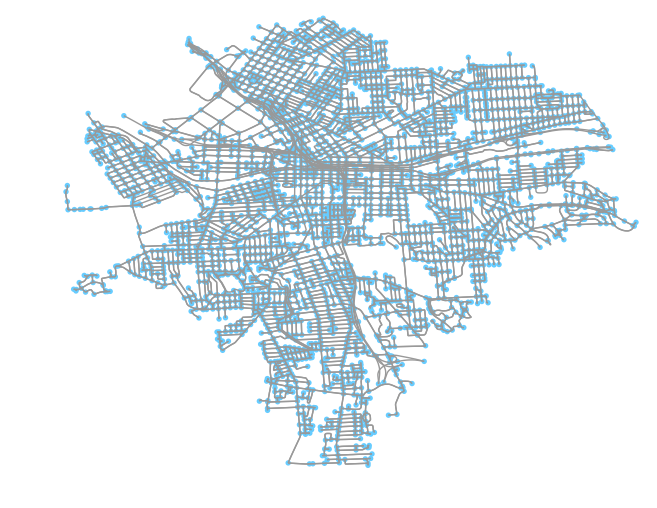

(<matplotlib.figure.Figure at 0x1aaa2612860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1aa9f633048>)

In [2]:
# Importing the City Network

G = ox.graph_from_place('Syracuse, USA', network_type='drive')
ox.plot_graph(G)

In [3]:
ox.save_graph_shapefile(G, filename='city_network')

In [4]:
# Loading the Edge Data

city_edge = gpd.read_file('Data/city_network/edges/edges.shp')
city_edge = city_edge[['osmid', 'name', 'geometry', 'length', 'highway', 'lanes']]
city_edge

,osmid,name,geometry,length,highway,lanes
0,"[295587203, 20129781]",East Brighton Avenue,"LINESTRING (-76.14297910000001 43.0206958, -76...",162.3436586089952,tertiary,"['3', '2']"
1,295587211,South State Street,"LINESTRING (-76.1409858 43.0209248, -76.140964...",58.446277978588654,primary,3
2,295587201,East Brighton Avenue,"LINESTRING (-76.1410327 43.0204078, -76.140840...",17.09061864608954,tertiary,2
3,20118797,South State Street,"LINESTRING (-76.1410327 43.0204078, -76.141056...",26.95234967010755,primary,2
4,20150830,Arthur Street,"LINESTRING (-76.17716900000001 43.034878, -76....",102.03312701271345,residential,None
5,20151137,Elliot Street,"LINESTRING (-76.17434799999999 43.035026, -76....",229.98832893180762,residential,None
6,20150830,Arthur Street,"LINESTRING (-76.17716900000001 43.034878, -76....",113.69256974760631,residential,None
7,"[221923218, 97100899, 97100870]",Erie Boulevard West,"LINESTRING (-76.15834099999999 43.0505691, -76...",111.41081105100533,secondary,4
8,221923217,Erie Boulevard West,"LINESTRING (-76.159645 43.050261, -76.160488 4...",71.93673507444657,secondary,4
9,20121299,None,"LINESTRING (-76.159738 43.04954, -76.159811 43...",88.01114439151769,motorway_link,1


In [5]:
# Loading Syracuse Accelerometer Data, Cleaning it up and making it into a Geodataframe

syra_acc = pd.read_csv('SQUID_SYRACUSE_MASTER_APR29.csv')
syra_acc = syra_acc[['Lat', 'Lon', 'Speed', 'X', 'Y', 'Z']]
syra_acc['vibration'] = ((syra_acc['X'])**2 + (syra_acc['Y'])**2 + (syra_acc['Z'])**2)**(1/2)
syra_acc = syra_acc[['Lat','Lon','Speed','vibration']]

geometry = gpd.GeoSeries([Point(xy) for xy in zip(syra_acc.Lon, syra_acc.Lat)])

syra_acc = gpd.GeoDataFrame(syra_acc, geometry=geometry)
syra_acc.crs = {'init' :'epsg:4326'}
syra_acc = syra_acc[['geometry','Speed','vibration',]]

syra_acc_x = syra_acc

syra_acc.head()

,geometry,Speed,vibration
0,POINT (-76.109782 43.055093),5.26,0.775284
1,POINT (-76.109803 43.055062),6.13,0.953227
2,POINT (-76.10984300000001 43.05498499999999),12.04,0.654811
3,POINT (-76.10987 43.054932),13.67,0.681340
4,POINT (-76.109898 43.054878),15.51,0.922900


In [6]:
city_edge_buff = gpd.GeoDataFrame(city_edge)
city_edge_buff['geometry'] = city_edge_buff.buffer(0.00013)
city_edge_buff.crs = {'init' :'epsg:4326'}
city_edge_buff.head()

,osmid,name,geometry,length,highway,lanes
0,"[295587203, 20129781]",East Brighton Avenue,POLYGON ((-76.14249922110189 43.02078881649258...,162.3436586089952,tertiary,"['3', '2']"
1,295587211,South State Street,POLYGON ((-76.14083864323719 43.02087057143594...,58.446277978588654,primary,3
2,295587201,East Brighton Avenue,POLYGON ((-76.14080055615388 43.02047013975223...,17.09061864608954,tertiary,2
3,20118797,South State Street,POLYGON ((-76.14092615478373 43.02027558277786...,26.95234967010755,primary,2
4,20150830,Arthur Street,POLYGON ((-76.17736664326172 43.03578437582774...,102.03312701271345,residential,None


In [7]:
geo_syra_acc = gpd.sjoin(syra_acc, city_edge_buff, how = 'inner', op = 'within')
#geo_syra_acc = geo_syra_acc[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc = geo_syra_acc[geo_syra_acc['highway'] == 'residential']
geo_syra_acc = geo_syra_acc[geo_syra_acc['lanes'].isin(['1', '2', '3', None])]
geo_syra_acc.reset_index(inplace=True)
geo_syra_acc = geo_syra_acc[['osmid', 'name', 'geometry', 'length', 'highway', 'lanes', 'Speed', 'vibration']]
geo_syra_acc.head()

,osmid,name,geometry,length,highway,lanes,Speed,vibration
0,20127617,Beattie Street,POINT (-76.108503 43.050898),252.30004574069568,residential,2,78.20,0.567579
1,20127617,Beattie Street,POINT (-76.108317 43.05069),252.30004574069568,residential,2,78.83,0.595571
2,20127617,Beattie Street,POINT (-76.10856 43.050723),252.30004574069568,residential,2,5.13,0.303975
3,20127617,Beattie Street,POINT (-76.10852299999999 43.050717),252.30004574069568,residential,2,5.66,0.374884
4,20127617,Beattie Street,POINT (-76.108503 43.05071),252.30004574069568,residential,2,5.93,0.526857


geo_syra_acc = geo_syra_acc[geo_syra_acc['Speed'] <= 70]

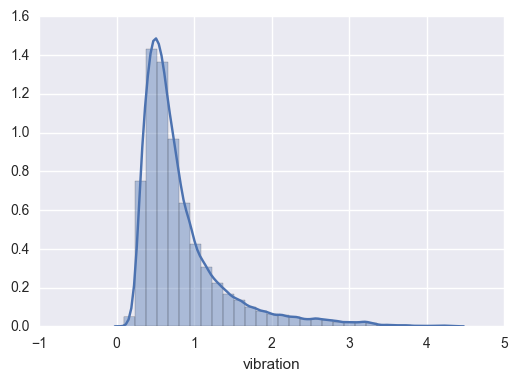

In [8]:
sns.distplot(geo_syra_acc['vibration'], kde=True, bins=30)

In [9]:
geo_syra_acc['vibration'].median()

0.6539067211766522

In [10]:
geo_syra_acc = geo_syra_acc.apply(pd.to_numeric, errors='ignore')

In [12]:
syra_acc_grp_1 = geo_syra_acc.groupby(by='osmid',axis=0).max()
syra_acc_grp_1.reset_index(inplace=True)
syra_acc_grp_2 = geo_syra_acc.groupby(by='osmid',axis=0).mean()
syra_acc_grp_2.reset_index(inplace=True)

In [13]:
syra_acc_grp = pd.merge(syra_acc_grp_1,syra_acc_grp_2,on='osmid')
syra_acc_grp = syra_acc_grp[['length_y','vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
syra_acc_grp = syra_acc_grp.apply(pd.to_numeric, errors='ignore')
syra_acc_grp.head()

,length_y,vibration_x,Speed_y
0,227.863283,1.730785,27.995000
1,168.407340,2.911115,16.513834
2,64.967075,0.775204,26.627778
3,106.853254,1.003004,19.262500
4,27.922998,1.203414,22.066000


In [15]:
syra_acc_grp_x = syra_acc_grp
syra_acc_grp_x.columns = ['Length','Max_vibration', 'Mean_Speed']

In [16]:
syra_acc_grp.dtypes

Length           float64
Max_vibration    float64
Mean_Speed       float64
dtype: object

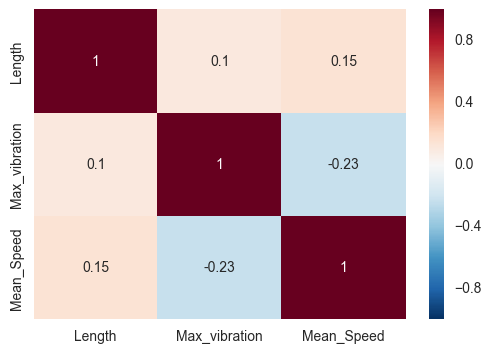

In [17]:
sns.heatmap(syra_acc_grp_x.corr(),annot=True)

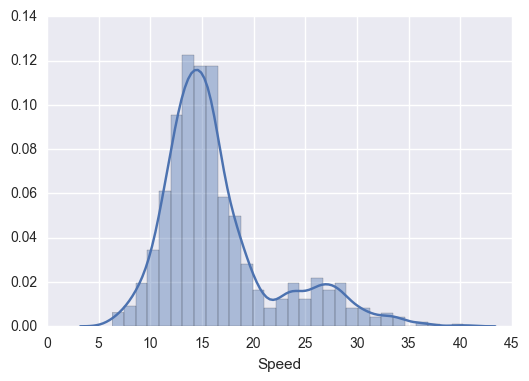

In [18]:
syra_acc_grp_x.columns = ['Length','vibration', 'Speed']
sns.distplot(syra_acc_grp_x['Speed'], kde=True, bins=30)

In [19]:
# SPlitting the Data into into Bins of 10mph

syra_acc_grp_1 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 10]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 10]

syra_acc_grp_2 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 20]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 20]

syra_acc_grp_3 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 30]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 30]

syra_acc_grp_4 = syra_acc_grp_x[syra_acc_grp_x['Speed'] < 40]
syra_acc_grp_x = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 40]

syra_acc_grp_5 = syra_acc_grp_x[syra_acc_grp_x['Speed'] >= 40]

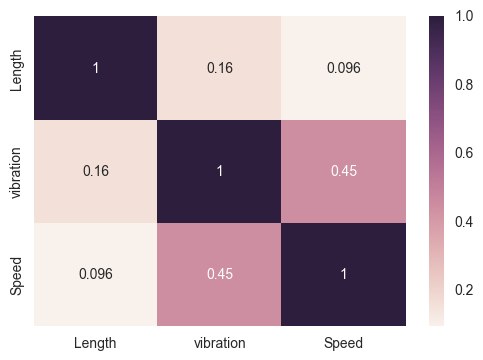

In [20]:
sns.heatmap(syra_acc_grp_1.corr(),annot=True)

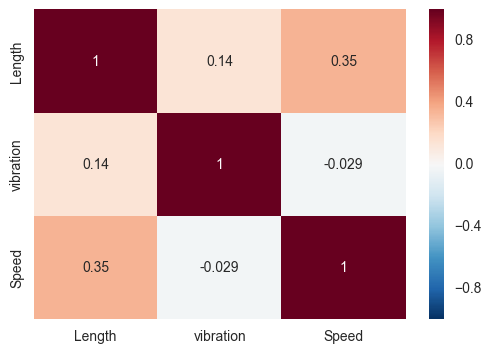

In [21]:
sns.heatmap(syra_acc_grp_2.corr(),annot=True)

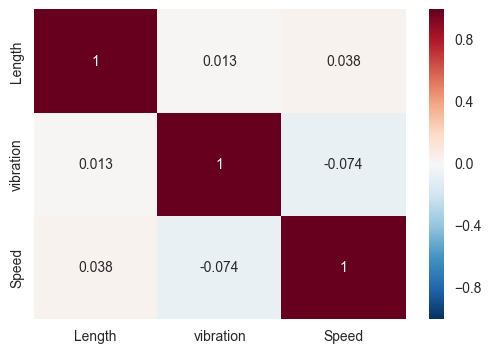

In [22]:
sns.heatmap(syra_acc_grp_3.corr(),annot=True)

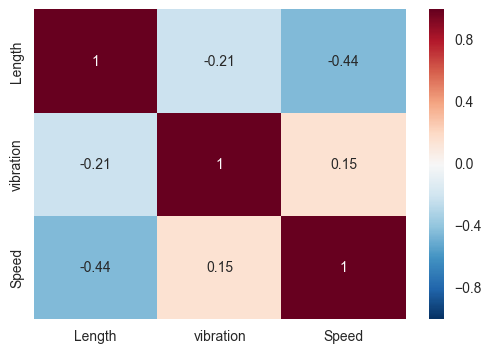

In [23]:
sns.heatmap(syra_acc_grp_4.corr(),annot=True)

In [27]:
# print(syra_acc_grp_1['0-10mph'].mean())
# print(syra_acc_grp_1['0-10mph'].median())

In [28]:
# print(syra_acc_grp_2['10-20mph'].mean())
# print(syra_acc_grp_2['10-20mph'].median())

In [29]:
# print(syra_acc_grp_3['20-30mph'].mean())
# print(syra_acc_grp_3['20-30mph'].median())

In [30]:
# print(syra_acc_grp_4['30-40mph'].mean())
# print(syra_acc_grp_4['30-40mph'].median())

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


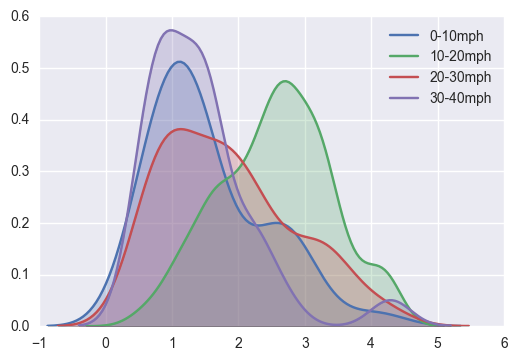

In [31]:
syra_acc_grp_1.rename(columns={'vibration': '0-10mph'},inplace=True)
syra_acc_grp_2.rename(columns={'vibration': '10-20mph'},inplace=True)
syra_acc_grp_3.rename(columns={'vibration': '20-30mph'},inplace=True)
syra_acc_grp_4.rename(columns={'vibration': '30-40mph'},inplace=True)
syra_acc_grp_5.rename(columns={'vibration': '> 40mph'},inplace=True)

sns.kdeplot(syra_acc_grp_1['0-10mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_2['10-20mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_3['20-30mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_4['30-40mph'], shade=True)
#sns.kdeplot(syra_acc_grp_5['> 40mph'], shade=True)

In [34]:
syra_acc_grp

,Length,vibration,Speed
0,227.863283,1.730785,27.995000
1,168.407340,2.911115,16.513834
2,64.967075,0.775204,26.627778
3,106.853254,1.003004,19.262500
4,27.922998,1.203414,22.066000
5,386.816565,3.166699,23.624404
6,59.176697,1.524568,6.545000
7,84.745029,2.083321,13.944458
8,124.829582,1.675858,14.320000
9,117.439538,2.990881,14.973333


# Regression

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(syra_acc_grp[['Length','vibration']])
y = pd.DataFrame(syra_acc_grp['Speed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

lm = LinearRegression()

results = lm.fit(X_train,y_train)

lm.coef_

cdf = pd.DataFrame(lm.coef_.transpose(),X.columns,columns=['Coeff'])
cdf

,Coeff
Length,0.009346
vibration,-1.336756


# OLS Regression

In [37]:
import statsmodels.api as sm


In [39]:
mod = sm.OLS(syra_acc_grp.Speed, syra_acc_grp.vibration)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Speed   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2316.
Date:                Thu, 11 May 2017   Prob (F-statistic):          8.14e-245
Time:                        05:22:39   Log-Likelihood:                -3075.9
No. Observations:                 850   AIC:                             6154.
Df Residuals:                     849   BIC:                             6159.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vibration      5.8564      0.122     48.126      0.0

ValueError: x and y must have same first dimension

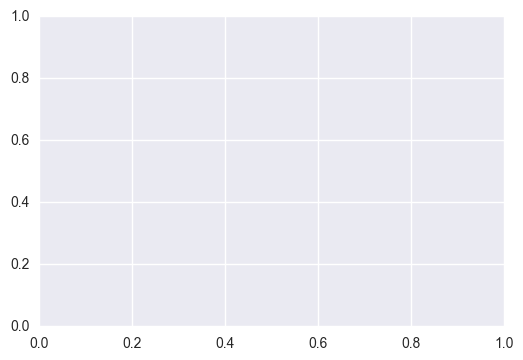

In [52]:
fig, ax = plt.subplots()
fig = plt.plot(res,syra_acc_grp.Speed)

# Trying to build a mean of the Larger Vibrations (Failed Experiment)

In [67]:
geo_syra_acc_y = geo_syra_acc
geo_syra_acc_y.head()

,osmid,name,geometry,length,highway,lanes,Speed,vibration
0,20127617,Beattie Street,POINT (-76.108503 43.050898),252.30004574069568,residential,2,78.20,0.567579
1,20127617,Beattie Street,POINT (-76.108317 43.05069),252.30004574069568,residential,2,78.83,0.595571
2,20127617,Beattie Street,POINT (-76.10856 43.050723),252.30004574069568,residential,2,5.13,0.303975
3,20127617,Beattie Street,POINT (-76.10852299999999 43.050717),252.30004574069568,residential,2,5.66,0.374884
4,20127617,Beattie Street,POINT (-76.108503 43.05071),252.30004574069568,residential,2,5.93,0.526857


In [72]:
geo_syra_acc_y = geo_syra_acc_y[geo_syra_acc_y['Speed'] < 70]
geo_syra_acc_y.reset_index(inplace=True)
geo_syra_acc_y = geo_syra_acc_y[['osmid', 'name', 'geometry', 'length', 'highway', 'lanes', 'Speed','vibration']]
geo_syra_acc_y.head()

,osmid,name,geometry,length,highway,lanes,Speed,vibration
0,20127617,Beattie Street,POINT (-76.10856 43.050723),252.30004574069568,residential,2,5.13,0.303975
1,20127617,Beattie Street,POINT (-76.10852299999999 43.050717),252.30004574069568,residential,2,5.66,0.374884
2,20127617,Beattie Street,POINT (-76.108503 43.05071),252.30004574069568,residential,2,5.93,0.526857
3,20127617,Beattie Street,POINT (-76.10847700000001 43.050697),252.30004574069568,residential,2,9.28,1.033124
4,20127617,Beattie Street,POINT (-76.108448 43.050673),252.30004574069568,residential,2,11.02,1.393457


In [73]:
geo_syra_acc_1 = geo_syra_acc_y[geo_syra_acc_y['Speed'] < 10]
geo_syra_acc_y = geo_syra_acc_y[geo_syra_acc_y['Speed'] >= 10]

geo_syra_acc_2 = geo_syra_acc_y[geo_syra_acc_y['Speed'] < 20]
geo_syra_acc_y = geo_syra_acc_y[geo_syra_acc_y['Speed'] >= 20]

geo_syra_acc_3 = geo_syra_acc_y[geo_syra_acc_y['Speed'] < 30]
geo_syra_acc_y = geo_syra_acc_y[geo_syra_acc_y['Speed'] >= 30]

geo_syra_acc_4 = geo_syra_acc_y[geo_syra_acc_y['Speed'] < 40]
geo_syra_acc_y = geo_syra_acc_y[geo_syra_acc_y['Speed'] >= 40]

geo_syra_acc_5 = geo_syra_acc_y[geo_syra_acc_y['Speed'] >= 40]

In [84]:
geo_syra_acc_1['vibration'].quantile(q=0.8)

0.7761243457075677

In [85]:
geo_syra_acc_2['vibration'].quantile(q=0.8)

1.1209335395107063

In [86]:
geo_syra_acc_3['vibration'].quantile(q=0.8)

1.3635098753817911

In [87]:
geo_syra_acc_4['vibration'].quantile(q=0.8)

1.4922207177207347

In [88]:
geo_syra_acc_5['vibration'].quantile(q=0.8)

1.2305933528180621

In [120]:
geo_syra_acc_grp_a = geo_syra_acc_1.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_a.reset_index(inplace=True)
geo_syra_acc_grp_b = geo_syra_acc.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_b.reset_index(inplace=True)

geo_syra_acc_grp_1 = pd.merge(geo_syra_acc_grp_a,geo_syra_acc_grp_b,on='osmid')
geo_syra_acc_grp_1 = geo_syra_acc_grp_1[['vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
geo_syra_acc_grp_1

,vibration_x,Speed_y
0,0.696253,16.513834
1,0.944096,23.624404
2,0.998404,6.545000
3,0.719652,13.944458
4,0.510202,14.320000
5,0.546616,14.973333
6,0.821905,15.167055
7,0.619734,13.770816
8,1.028583,11.224773
9,0.662757,11.343529


In [108]:
geo_syra_acc_grp_a = geo_syra_acc_2.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_a.reset_index(inplace=True)
geo_syra_acc_grp_b = geo_syra_acc.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_b.reset_index(inplace=True)

geo_syra_acc_grp_2 = pd.merge(geo_syra_acc_grp_a,geo_syra_acc_grp_b,on='osmid')
geo_syra_acc_grp_2 = geo_syra_acc_grp_2[['vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
geo_syra_acc_grp_2

,vibration_x,Speed_y
0,0.956830,16.513834
1,0.422730,26.627778
2,0.614008,19.262500
3,0.480824,22.066000
4,1.108015,23.624404
5,0.763585,13.944458
6,0.489007,14.320000
7,0.722970,14.973333
8,0.867121,15.167055
9,0.526085,16.573333


In [109]:
geo_syra_acc_grp_a = geo_syra_acc_3.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_a.reset_index(inplace=True)
geo_syra_acc_grp_b = geo_syra_acc.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_b.reset_index(inplace=True)

geo_syra_acc_grp_3 = pd.merge(geo_syra_acc_grp_a,geo_syra_acc_grp_b,on='osmid')
geo_syra_acc_grp_3 = geo_syra_acc_grp_3[['vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
geo_syra_acc_grp_3

,vibration_x,Speed_y
0,0.993346,27.995000
1,1.298206,16.513834
2,0.566718,26.627778
3,0.526696,19.262500
4,0.669265,22.066000
5,1.245342,23.624404
6,0.547110,13.944458
7,0.904653,14.320000
8,1.230158,14.973333
9,0.980745,15.167055


In [110]:
geo_syra_acc_grp_a = geo_syra_acc_4.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_a.reset_index(inplace=True)
geo_syra_acc_grp_b = geo_syra_acc.groupby(by='osmid',axis=0).mean()
geo_syra_acc_grp_b.reset_index(inplace=True)

geo_syra_acc_grp_4 = pd.merge(geo_syra_acc_grp_a,geo_syra_acc_grp_b,on='osmid')
geo_syra_acc_grp_4 = geo_syra_acc_grp_4[['vibration_x', 'Speed_y']]
#syra_acc_grp = syra_acc_grp[['osmid', 'name', 'length', 'vibration_y', 'Speed_x']]
#syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
geo_syra_acc_grp_4

,vibration_x,Speed_y
0,1.095028,23.624404
1,0.992506,30.845000
2,0.454743,33.070000
3,0.749444,16.563256
4,1.280264,18.757064
5,0.530871,13.576842
6,0.609031,33.056667
7,1.881714,13.561098
8,0.807509,12.787679
9,0.781679,15.583748


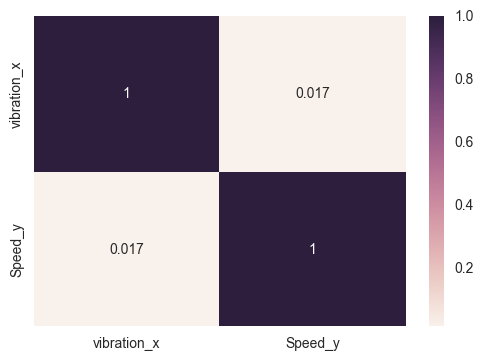

In [113]:
sns.heatmap(geo_syra_acc_grp_1.corr(),annot=True)

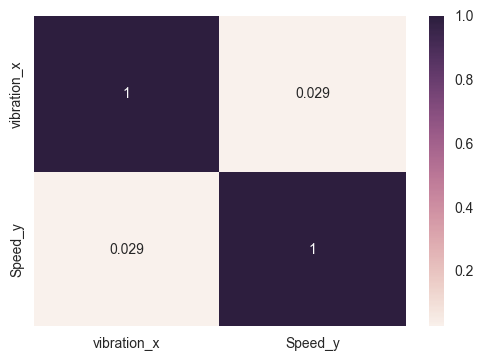

In [114]:
sns.heatmap(geo_syra_acc_grp_2.corr(),annot=True)

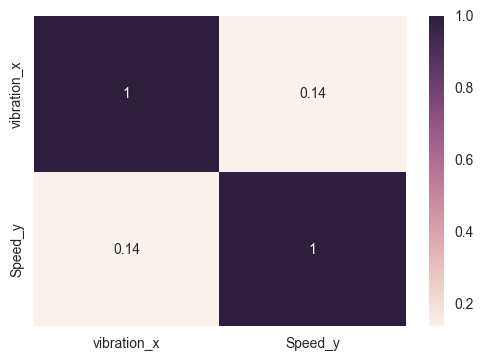

In [115]:
sns.heatmap(geo_syra_acc_grp_3.corr(),annot=True)

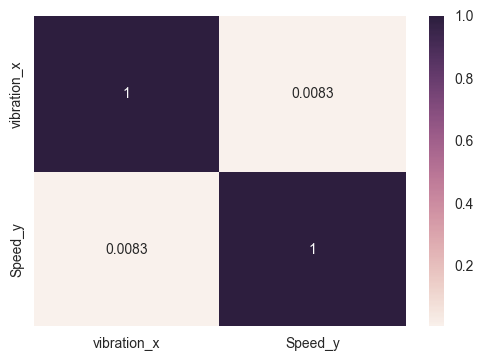

In [116]:
sns.heatmap(geo_syra_acc_grp_4.corr(),annot=True)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


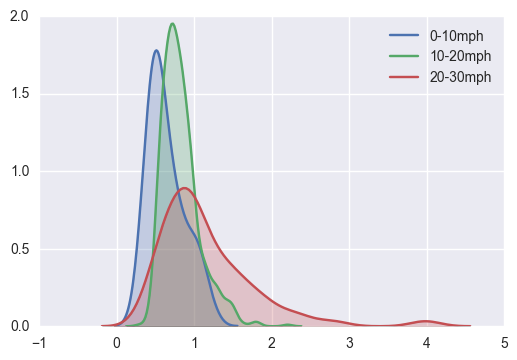

In [40]:
syra_acc_grp_1.rename(columns={'vibration': '0-10mph'},inplace=True)
syra_acc_grp_2.rename(columns={'vibration': '10-20mph'},inplace=True)
syra_acc_grp_3.rename(columns={'vibration': '20-30mph'},inplace=True)
syra_acc_grp_4.rename(columns={'vibration': '30-40mph'},inplace=True)
syra_acc_grp_5.rename(columns={'vibration': '> 40mph'},inplace=True)

#sns.kdeplot(syra_acc_grp_1['0-10mph'], shade=True, legend=True)
#sns.kdeplot(syra_acc_grp_2['10-20mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_grp_3['20-30mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_4['30-40mph'], shade=True)
sns.kdeplot(syra_acc_5['> 40mph'], shade=True)

NameError: name 'syra_acc_4' is not defined

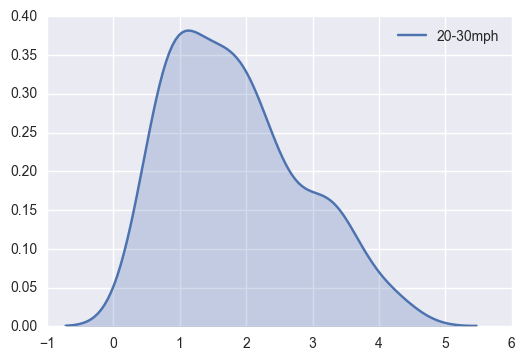

In [39]:
sns.kdeplot(syra_acc_grp_3['20-30mph'], shade=True, legend=True)
sns.kdeplot(syra_acc_4['30-40mph'], shade=True)
sns.kdeplot(syra_acc_5['> 40mph'], shade=True)

In [77]:
syra_acc_4_75 = syra_acc_4[syra_acc_4['vibration'] > syra_acc_4['vibration'].quantile(q=0.75)]
syra_acc_4_75.head()

,Speed,vibration
58,30.01,1.553708
59,30.84,1.163869
97,36.63,2.165763
101,39.51,1.005450
118,35.11,1.083583


In [77]:
syra_acc_4_75 = syra_acc_4[syra_acc_4['vibration'] > syra_acc_4['vibration'].quantile(q=0.75)]
syra_acc_4_75.head()

,Speed,vibration
58,30.01,1.553708
59,30.84,1.163869
97,36.63,2.165763
101,39.51,1.005450
118,35.11,1.083583


In [42]:
syra_acc_grp_1.rename(columns={'0-10mph' : 'vibration'},inplace=True)
syra_acc_grp_2.rename(columns={'10-20mph' : 'vibration'},inplace=True)
syra_acc_grp_3.rename(columns={'20-30mph' : 'vibration'},inplace=True)
syra_acc_grp_4.rename(columns={'30-40mph' : 'vibration'},inplace=True)
syra_acc_grp_5.rename(columns={'> 40mph' : 'vibration'},inplace=True)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


1.2043629527187067

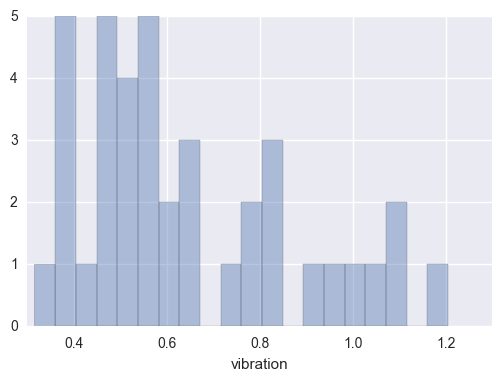

In [55]:
sns.distplot(syra_acc_1['vibration'], kde=False, bins=30)
syra_acc_1['vibration'].max()

0.7836208205088736

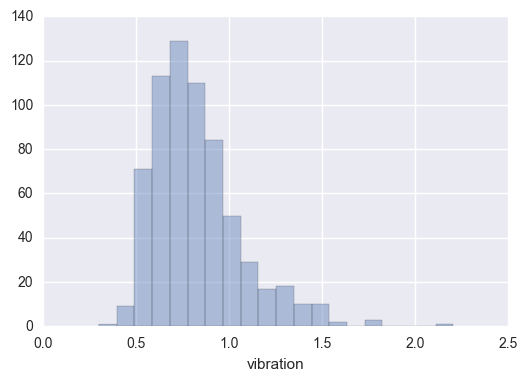

In [54]:
sns.distplot(syra_acc_2['vibration'], kde=False, bins=10)
syra_acc_2['vibration'].median()

1.014717595801227

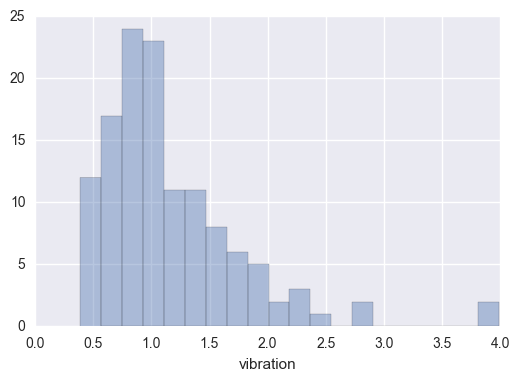

In [53]:
sns.distplot(syra_acc_3['vibration'], kde=False, bins=30)
syra_acc_3['vibration'].median()

0.9089272146567202

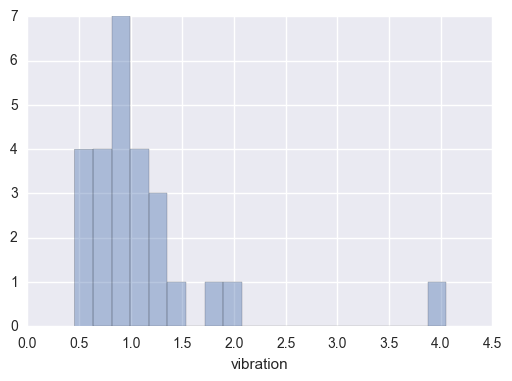

In [56]:
sns.distplot(syra_acc_grp_4['vibration'], kde=False, bins=20)
syra_acc_grp_4['vibration'].median()

In [59]:
syra_acc_1['vibration'].quantile(q=0.75)

0.7968900317353945

In [60]:
syra_acc_2['vibration'].quantile(q=0.75)

0.9411348344993293

In [61]:
syra_acc_3['vibration'].quantile(q=0.75)

1.4151861638233143

In [62]:
syra_acc_4['vibration'].quantile(q=0.75)

1.1819968171035975

In [63]:
syra_acc_5['vibration'].quantile(q=0.75)

0.8726084217918424

In [27]:
syra_acc_1_75 = syra_acc_1[syra_acc_1['vibration'] > syra_acc_1['vibration'].quantile(q=0.75)]
syra_acc_1_75.head()

,geometry,Speed,vibration
0,POINT (-76.109782 43.055093),5.26,0.775284
1,POINT (-76.109803 43.055062),6.13,0.953227
38,POINT (-76.115433 43.05432800000001),8.56,1.131464
41,POINT (-76.115588 43.054152),5.92,0.996979
42,POINT (-76.115595 43.054102),8.08,1.391529


In [28]:
syra_acc_2_75 = syra_acc_2[syra_acc_2['vibration'] > syra_acc_2['vibration'].quantile(q=0.75)]
syra_acc_2_75.head()

,geometry,Speed,vibration
5,POINT (-76.10993499999999 43.054815),18.52,1.624532
6,POINT (-76.109962 43.05475300000001),19.51,3.336175
7,POINT (-76.10998000000001 43.054688),19.63,1.771088
37,POINT (-76.115392 43.054305),10.68,1.251016
45,POINT (-76.115588 43.053918),13.95,1.605087


In [29]:
syra_acc_3_75 = syra_acc_3[syra_acc_3['vibration'] > syra_acc_3['vibration'].quantile(q=0.75)]
syra_acc_3_75.head()

,geometry,Speed,vibration
8,POINT (-76.109962 43.054623),20.05,2.120014
9,POINT (-76.109965 43.054515),24.62,1.956245
50,POINT (-76.115567 43.053533),21.35,1.301599
51,POINT (-76.11556 43.053445),22.72,1.845434
52,POINT (-76.11555300000001 43.05332),25.43,1.223935


In [30]:
syra_acc_4_75 = syra_acc_4[syra_acc_4['vibration'] > syra_acc_4['vibration'].quantile(q=0.75)]
syra_acc_4_75.head()

,geometry,Speed,vibration
58,POINT (-76.115482 43.052695),30.01,1.553708
59,POINT (-76.11547 43.052577),30.84,1.163869
97,POINT (-76.11685799999999 43.050627),36.63,2.165763
101,POINT (-76.117498 43.050425),39.51,1.005450
118,POINT (-76.12042199999999 43.049713),35.11,1.083583


In [31]:
syra_acc_5_75 = syra_acc_5[syra_acc_5['vibration'] > syra_acc_5['vibration'].quantile(q=0.75)]
syra_acc_5_75.head()

,geometry,Speed,vibration
10,POINT (-76.109967 43.054345),43.37,1.961604
103,POINT (-76.11783199999999 43.050318),40.39,1.038839
104,POINT (-76.117998 43.05027),40.75,0.984663
105,POINT (-76.11816800000001 43.05022),41.29,0.945153
106,POINT (-76.11834 43.050168),41.62,2.192508


,from,geometry,length,name,oneway,osmid,to
0,212794664,POLYGON ((-76.14249922110189 43.02078881649258...,162.3436586089952,East Brighton Avenue,False,"[295587203, 20129781]",212729857
1,2993234824,POLYGON ((-76.14083864323719 43.02087057143594...,58.446277978588654,South State Street,True,295587211,212729857
2,212842338,POLYGON ((-76.14080055615388 43.02047013975223...,17.09061864608954,East Brighton Avenue,False,295587201,212729857
3,212729857,POLYGON ((-76.14092615478373 43.02027558277786...,26.95234967010755,South State Street,True,20118797,1862571647
4,212880121,POLYGON ((-76.17736664326172 43.03578437582774...,102.03312701271345,Arthur Street,False,20150830,213114883


In [33]:
geo_syra_acc_1_75 = gpd.sjoin(syra_acc_1_75,city_edge_buff, how = 'inner', op = 'within')
geo_syra_acc_1_75 = geo_syra_acc_1_75[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc_1_75.head()

,osmid,geometry,length,Speed,vibration
0,"[425223723, 20140964]",POINT (-76.109782 43.055093),1022.0696897152164,5.26,0.775284
1,"[425223723, 20140964]",POINT (-76.109803 43.055062),1022.0696897152164,6.13,0.953227
38,"[425223723, 20140964]",POINT (-76.115433 43.05432800000001),1022.0696897152164,8.56,1.131464
41,"[425223723, 20140964]",POINT (-76.115588 43.054152),1022.0696897152164,5.92,0.996979
42,"[425223723, 20140964]",POINT (-76.115595 43.054102),1022.0696897152164,8.08,1.391529


In [34]:
geo_syra_acc_2_75 = gpd.sjoin(syra_acc_2_75,city_edge_buff, how = 'inner', op = 'within')
geo_syra_acc_2_75 = geo_syra_acc_2_75[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc_2_75.head()

,osmid,geometry,length,Speed,vibration
37,"[425223723, 20140964]",POINT (-76.115392 43.054305),1022.0696897152164,10.68,1.251016
5706,"[425223723, 20140964]",POINT (-76.11544000000001 43.05419000000001),1022.0696897152164,12.83,1.688223
5723,"[425223723, 20140964]",POINT (-76.11468499999999 43.053983),1022.0696897152164,14.99,1.756943
5724,"[425223723, 20140964]",POINT (-76.11461 43.053988),1022.0696897152164,17.40,2.347602
5767,"[425223723, 20140964]",POINT (-76.11054799999999 43.05501),1022.0696897152164,17.77,1.360365


In [35]:
geo_syra_acc_3_75 = gpd.sjoin(syra_acc_3_75,city_edge_buff, how = 'inner', op = 'within')
geo_syra_acc_3_75 = geo_syra_acc_3_75[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc_3_75.head()

,osmid,geometry,length,Speed,vibration
50,305092206,POINT (-76.115567 43.053533),113.63627584322606,21.35,1.301599
51,305092206,POINT (-76.11556 43.053445),113.63627584322606,22.72,1.845434
52,305092206,POINT (-76.11555300000001 43.05332),113.63627584322606,25.43,1.223935
53,305092206,POINT (-76.11554699999999 43.053203),113.63627584322606,27.14,2.413731
54,305092206,POINT (-76.11554 43.053102),113.63627584322606,28.23,2.376516


In [36]:
geo_syra_acc_4_75 = gpd.sjoin(syra_acc_4_75,city_edge_buff, how = 'inner', op = 'within')
geo_syra_acc_4_75 = geo_syra_acc_4_75[['osmid','geometry', 'length','Speed','vibration']]
geo_syra_acc_4_75.head()

,osmid,geometry,length,Speed,vibration
58,305092206,POINT (-76.115482 43.052695),113.63627584322606,30.01,1.553708
59,305092206,POINT (-76.11547 43.052577),113.63627584322606,30.84,1.163869
59,20140317,POINT (-76.11547 43.052577),163.27360532416873,30.84,1.163869
59,305092206,POINT (-76.11547 43.052577),52.46415847995873,30.84,1.163869
97,193891600,POINT (-76.11685799999999 43.050627),204.32372166886267,36.63,2.165763


In [37]:
geo_syra_acc_5_75 = gpd.sjoin(syra_acc_5_75,city_edge_buff, how = 'inner', op = 'within')
geo_syra_acc_5_75 = geo_syra_acc_5_75[['osmid','geometry','length','Speed','vibration']]
geo_syra_acc_5_75.head()

,osmid,geometry,length,Speed,vibration
103,193891600,POINT (-76.11783199999999 43.050318),204.32372166886267,40.39,1.038839
104,193891600,POINT (-76.117998 43.05027),204.32372166886267,40.75,0.984663
105,193891600,POINT (-76.11816800000001 43.05022),204.32372166886267,41.29,0.945153
106,193891600,POINT (-76.11834 43.050168),204.32372166886267,41.62,2.192508
107,193891600,POINT (-76.118512 43.050117),204.32372166886267,41.68,1.021408


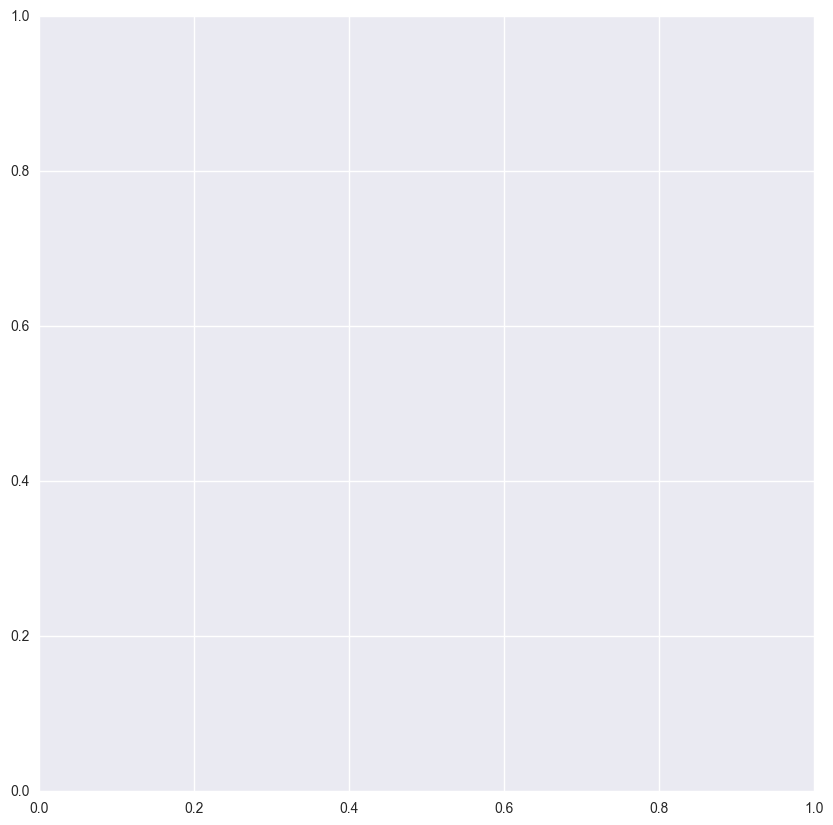

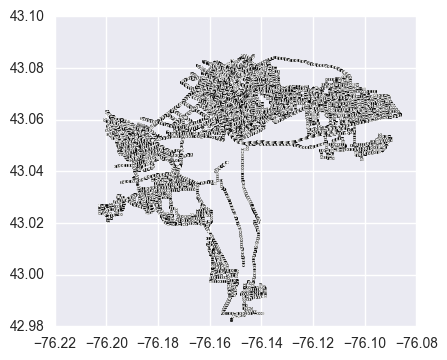

In [43]:
f, ax = plt.subplots(figsize=(10,10))
syra_acc.plot()

In [61]:
x = syra_acc[syra_acc['Speed'] >35]

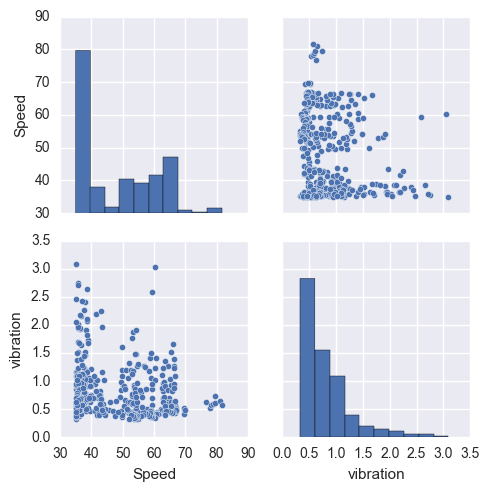

In [62]:
sns.pairplot(x)

TypeError: float() argument must be a string or a number, not 'Point'

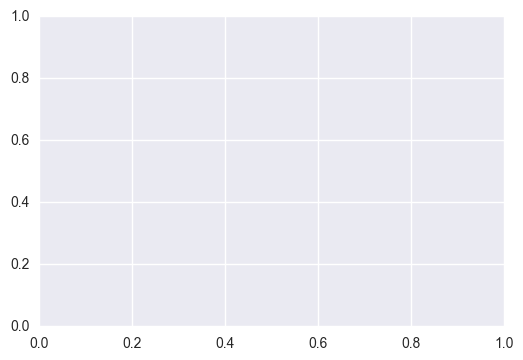

In [63]:
plt.plot(x)

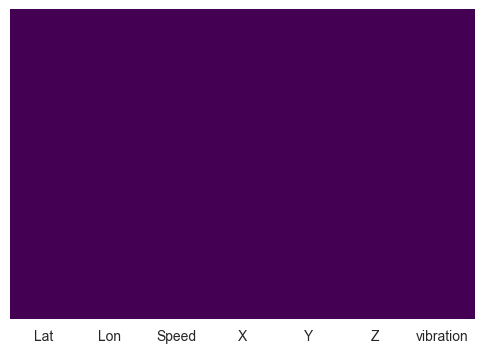

In [8]:
# Checking for Missing Data

sns.heatmap(syra_acc.isnull(),yticklabels=False,cbar=False,cmap='viridis')

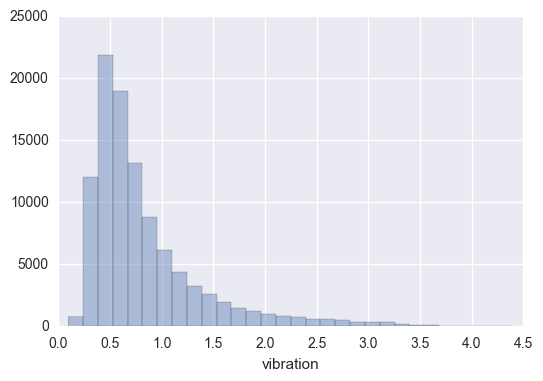

In [9]:
#Checking the Distribution of Vibration Data

sns.distplot(syra_acc['vibration'], kde=False, bins=30)

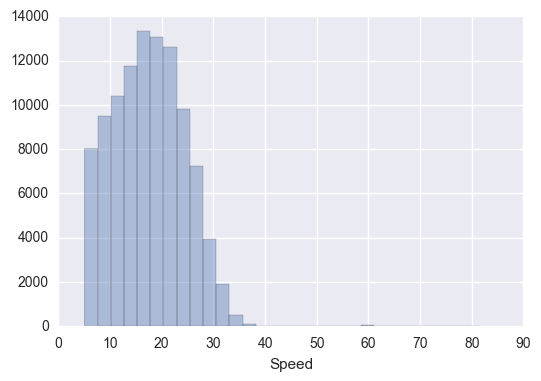

In [10]:
#Checking the Distribution of Speed Data

# Since this is a Controlled Experiment where the driver is driving carefully, the 

sns.distplot(syra_acc['Speed'], kde=False, bins=30)

In [13]:
syra_acc.dtypes

Lat          float64
Lon          float64
Speed        float64
X            float64
Y            float64
Z            float64
vibration    float64
category      object
dtype: object

In [14]:
syra_acc['category'] = '0'
syra_acc.category[syra_acc['vibration'] > 1] = 'Cat_2'
syra_acc.category[syra_acc['vibration'] > 2] = 'Cat_1'
syra_acc.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Lat,Lon,Speed,X,Y,Z,vibration,category
0,43.055093,-76.109782,5.26,0.400,0.539,0.388,0.775284,0
1,43.055062,-76.109803,6.13,0.396,0.543,0.676,0.953227,0
2,43.054985,-76.109843,12.04,0.332,0.483,0.292,0.654811,0
3,43.054932,-76.109870,13.67,0.372,0.268,0.504,0.681340,0
4,43.054878,-76.109898,15.51,0.612,0.356,0.592,0.922900,0


In [15]:
syra_acc[syra_acc['Speed'] < 50]

,Lat,Lon,Speed,X,Y,Z,vibration,category
0,43.055093,-76.109782,5.26,0.400,0.539,0.388,0.775284,0
1,43.055062,-76.109803,6.13,0.396,0.543,0.676,0.953227,0
2,43.054985,-76.109843,12.04,0.332,0.483,0.292,0.654811,0
3,43.054932,-76.109870,13.67,0.372,0.268,0.504,0.681340,0
4,43.054878,-76.109898,15.51,0.612,0.356,0.592,0.922900,0
5,43.054815,-76.109935,18.52,1.072,0.639,1.040,1.624532,Cat_2
6,43.054753,-76.109962,19.51,1.351,2.092,2.220,3.336175,Cat_1
7,43.054688,-76.109980,19.63,0.827,0.696,1.403,1.771088,Cat_2
8,43.054623,-76.109962,20.05,1.063,1.303,1.291,2.120014,Cat_1
9,43.054515,-76.109965,24.62,1.072,0.616,1.516,1.956245,Cat_2


In [16]:
city_edge_buff = gpd.GeoDataFrame(city_edge)
city_edge_buff['geometry'] = city_edge_buff.buffer(0.00013)
city_edge_buff.crs = {'init' :'epsg:4326'}
city_edge_buff.head()

,from,geometry,length,name,oneway,osmid,to
0,212794664,POLYGON ((-76.14249922110189 43.02078881649258...,162.3436586089952,East Brighton Avenue,False,"[295587203, 20129781]",212729857
1,2993234824,POLYGON ((-76.14083864323719 43.02087057143594...,58.446277978588654,South State Street,True,295587211,212729857
2,212842338,POLYGON ((-76.14080055615388 43.02047013975223...,17.09061864608954,East Brighton Avenue,False,295587201,212729857
3,212729857,POLYGON ((-76.14092615478373 43.02027558277786...,26.95234967010755,South State Street,True,20118797,1862571647
4,212880121,POLYGON ((-76.17736664326172 43.03578437582774...,102.03312701271345,Arthur Street,False,20150830,213114883


In [17]:
geometry = gpd.GeoSeries([Point(xy) for xy in zip(syra_acc.Lon, syra_acc.Lat)])

In [16]:
syra_acc = gpd.GeoDataFrame(syra_acc, geometry=geometry)
syra_acc.crs = {'init' :'epsg:4326'}
syra_acc = syra_acc[['geometry','Speed','vibration',]]

syra_acc.head()

,Speed,vibration,category,geometry
0,5.26,0.775284,0,POINT (-76.109782 43.055093)
1,6.13,0.953227,0,POINT (-76.109803 43.055062)
2,12.04,0.654811,0,POINT (-76.10984300000001 43.05498499999999)
3,13.67,0.681340,0,POINT (-76.10987 43.054932)
4,15.51,0.922900,0,POINT (-76.109898 43.054878)


In [17]:
geo_syra_acc = gpd.sjoin(syra_acc,city_edge_buff, how = 'inner', op = 'within')

In [18]:
geo_syra_acc.columns

Index(['Speed', 'vibration', 'category', 'geometry', 'index_right', 'from',
       'length', 'name', 'oneway', 'osmid', 'to'],
      dtype='object')

In [19]:
geo_syra_acc = geo_syra_acc[['Speed','vibration','category','geometry','osmid','length']]

In [20]:
geo_syra_acc.head()

,Speed,vibration,category,geometry,osmid,length
0,5.26,0.775284,0,POINT (-76.109782 43.055093),"[425223723, 20140964]",1022.0696897152164
1,6.13,0.953227,0,POINT (-76.109803 43.055062),"[425223723, 20140964]",1022.0696897152164
2,12.04,0.654811,0,POINT (-76.10984300000001 43.05498499999999),"[425223723, 20140964]",1022.0696897152164
3,13.67,0.681340,0,POINT (-76.10987 43.054932),"[425223723, 20140964]",1022.0696897152164
4,15.51,0.922900,0,POINT (-76.109898 43.054878),"[425223723, 20140964]",1022.0696897152164


In [65]:
geo_syra_acc = geo_syra_acc[['osmid','length','Speed','vibration']]
geo_syra_acc

,osmid,length,Speed,vibration
0,"[425223723, 20140964]",1022.069690,5.26,0.775284
1,"[425223723, 20140964]",1022.069690,6.13,0.953227
2,"[425223723, 20140964]",1022.069690,12.04,0.654811
3,"[425223723, 20140964]",1022.069690,13.67,0.681340
4,"[425223723, 20140964]",1022.069690,15.51,0.922900
29,"[425223723, 20140964]",1022.069690,13.33,0.633896
30,"[425223723, 20140964]",1022.069690,14.09,0.701952
35,"[425223723, 20140964]",1022.069690,13.86,0.466949
36,"[425223723, 20140964]",1022.069690,12.28,0.458417
37,"[425223723, 20140964]",1022.069690,10.68,1.251016


In [22]:
geo_syra_acc['length'] = pd.to_numeric(geo_syra_acc['length'])

In [23]:
geo_syra_acc.dtypes

osmid         object
length       float64
Speed        float64
vibration    float64
dtype: object

In [53]:
syra_acc_grp_1 = geo_syra_acc.groupby(by='osmid',axis=0).mean()
syra_acc_grp_1.reset_index(inplace=True)
syra_acc_grp_2 = geo_syra_acc.groupby(by='osmid',axis=0).max()
syra_acc_grp_2.reset_index(inplace=True)

In [60]:
syra_acc_grp = pd.merge(syra_acc_grp_1,syra_acc_grp_2,on='osmid')
syra_acc_grp = syra_acc_grp[['length_x','vibration_y','Speed_x']]
syra_acc_grp.columns = ['Length','Max_Vibration','mean_speed']
syra_acc_grp.head()

,Length,Max_Vibration,mean_speed
0,210.270525,3.366004,17.823795
1,278.648160,2.816035,25.993205
2,29.700779,2.639562,11.486957
3,227.863283,1.730785,27.995000
4,168.407340,2.911115,16.513834


In [61]:
# Bin the speeds by 10mph and check the correlations

# Time Series of Vibration over time and Speed over time on the same plot


# Cluster the similar data points and do the analysis

In [62]:


# Mean Vibration vs Mean Speed 

# Expected - Negative Correlation
# Reality - Positive Correlation

# Possible Reason - As vehicle Speed increases up until a point, the suspension vibrations tend to increase.
# Since we are dealing mostly with speeds less than 40mph, this vibrations are still increasing with speed


# Mean Vibration vs Std Speed

# Expected - Positive Correlation
# Reality - Negative Correlation

# Possible Reason - This is not very clear


# Max Vibration vs Mean Speed

# Expected - Negative Correlation
# Reality - Negative Correlation

# Possible Reason - The presence of a major road defect leads to drastic decrease in speed of the vehicles within that stretch
# of road

# Max Vibration vs Std Speed

# Expected - Positive Correlation
# Reality - Positive Correlation


In [63]:
syra_acc_grp.dtypes

Length           float64
Max_Vibration    float64
mean_speed       float64
dtype: object

In [64]:
syra_acc_grp.corr()

,Length,Max_Vibration,mean_speed
Length,1.000000,0.014801,0.325763
Max_Vibration,0.014801,1.000000,-0.177737
mean_speed,0.325763,-0.177737,1.000000


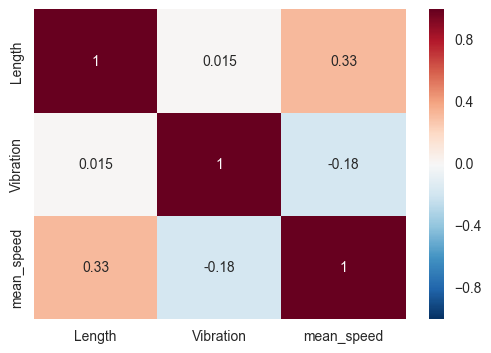

In [59]:
sns.heatmap(syra_acc_grp.corr(),annot=True)

# Regression

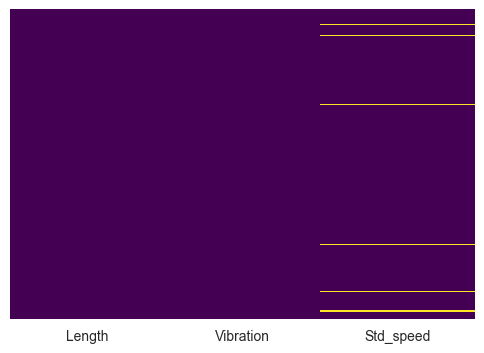

In [29]:
sns.heatmap(syra_acc_grp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [30]:
syra_acc_grp.dropna(inplace=True)

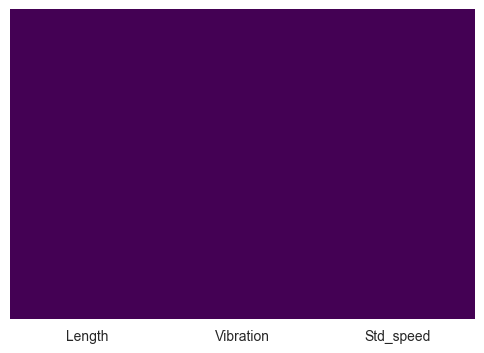

In [31]:
sns.heatmap(syra_acc_grp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

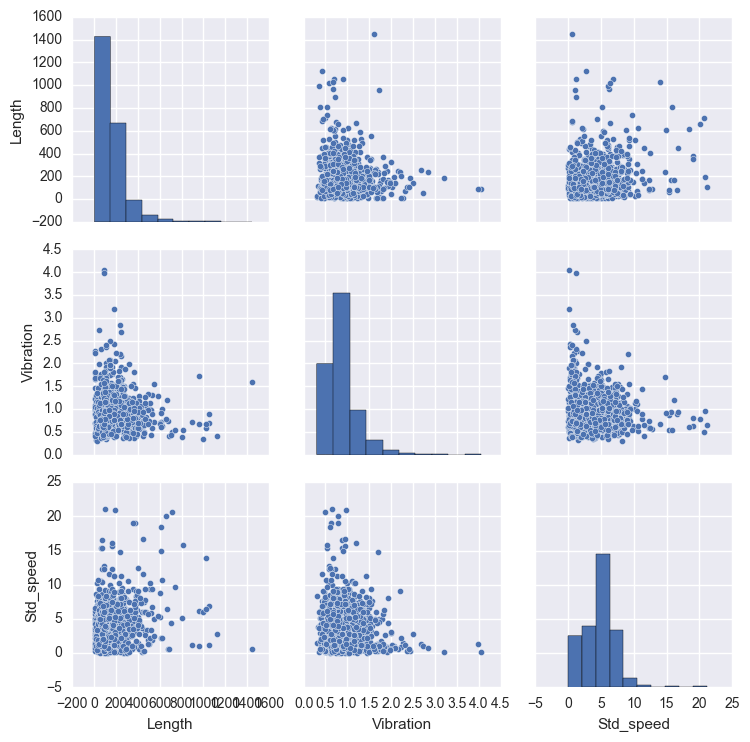

In [32]:
sns.pairplot(syra_acc_grp)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(syra_acc_grp[['Length','Vibration']])
y = pd.DataFrame(syra_acc_grp['Std_speed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

lm = LinearRegression()

results = lm.fit(X_train,y_train)

lm.coef_

cdf = pd.DataFrame(lm.coef_.transpose(),X.columns,columns=['Coeff'])
cdf

In [34]:
X.shape

(1403, 2)

array([[ 0.00257112, -1.3331326 ]])

,Coeff
Length,0.002571
Vibration,-1.333133


# Predictions

In [50]:
predictions = lm.predict(X_test)

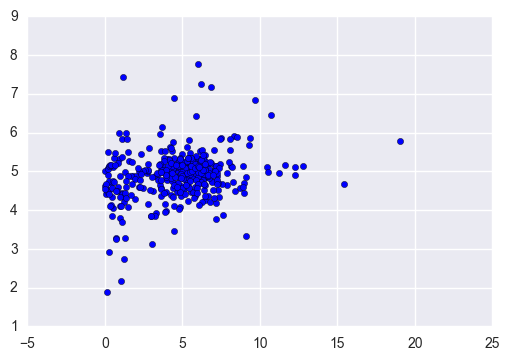

In [51]:
plt.scatter(y_test,predictions)

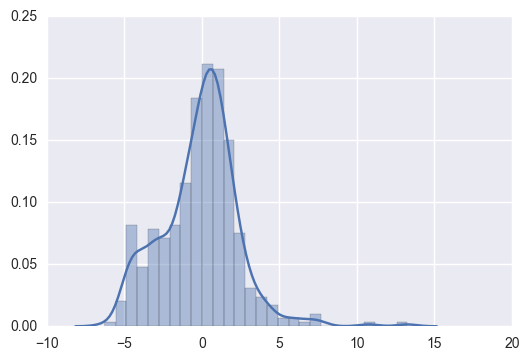

In [52]:
sns.distplot((y_test-predictions))

# Regression Metrics

In [53]:
from sklearn import metrics

In [54]:
print('MAE: ', metrics.mean_absolute_error(y_test,predictions))
print('MSE: ', metrics.mean_squared_error(y_test,predictions))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE:  1.83552194737
MSE:  6.11350355344
RMSE:  2.4725500103
